In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from tensorflow.keras import mixed_precision
import tensorflow_probability as tfp
from tensorflow_addons.optimizers import CyclicalLearningRate
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.registration import phase_cross_correlation
from scipy import io
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
import copy
import os
base_path = os.environ['HOME']

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [3]:
print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.threading.set_intra_op_parallelism_threads(24 * len(gpus))
tf.config.threading.set_inter_op_parallelism_threads(24 * len(gpus))

In [5]:
if len(gpus):
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Restricting Memory")
    except RuntimeError as e:
        print(e)
    policy = mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.experimental.set_policy(policy)

tf.config.set_soft_device_placement(False)

Restricting Memory
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB, compute capability 8.0
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


2022-04-29 10:59:50.673197: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-29 10:59:52.824427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38428 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [6]:
tf.config.get_soft_device_placement(), gpus[0]

(False, PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'))

In [7]:
gpus[0].name

'/physical_device:GPU:0'

In [8]:
!pwd

/gpfs/fs1/home/skandel/code/mbptycho/mbptycho/tests/two_edge_sparse_scan/apodized_probe_weak_peaks


In [9]:
strain_type = 'two_edge_slip'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/apodized_probe_weak_peaks'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'


In [10]:
!ls $sim_data_path

/home/skandel/code/mbptycho/experiments/python/two_edge_slip_sparse/apodized_probe_weak_peaks/sim_two_edge_slip.pkl


In [11]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.params.sample_pix_size

File exists. Reloading...


0.005844363636363636

## Directly reconstructing the displacements

In [13]:
recons = DisplacementFullModelReconstruction(simulation=sm, #ux_uy_2d_init=t1, magnitudes_init=t2,
                                             shared_magnitudes=True, 
                                             unwrap_phase_proj=True, 
                                             batch_size=50)

Setting background_level to 1e-08...


In [14]:
disp_lr = 1e-2
magnitude_lr = 1e-2
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.01>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x154628c8f400>,
  'var': <tf.Variable 'ux_uy:0' shape=(16530,) dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.01>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x154628c8f3a0>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(8268,) dtype=float32, numpy=
  array([-16.118095, -16.118095, -16.118095, ...,   0.      ,   0.      ,
           0.      ], dtype=float32)>}}

In [15]:
recons.minimize(1000, debug_output_epoch_frequency=10)

Initializing the datalog...
<tf.Variable 'Variable:0' shape=(50,) dtype=int32>
Instructions for updating:
Use fn_output_signature instead
<tf.Variable 'Variable:0' shape=(50,) dtype=int32>


2022-04-29 11:03:02.576571: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-29 11:03:06.676373: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


        epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
60         10    1.43e+06      0.784      0.822        0.722        0.769      0.797      0.797      0.781      0.808          0.756          0.744          0.739          0.764
120         20   1.35e+06      0.785       0.75      0.805      0.625      0.785       0.73      0.702      0.707      0.732      0.663      0.613      0.656
180         30   1.46e+06      0.755      0.734      0.727        0.6      0.764      0.676      0.703      0.755      0.708      0.571      0.606      0.715
240         40   1.08e+06      0.738      0.727      0.678      0.596      0.771      0.696      0.719      0.768      0.694      0.574      0.608      0.693
300         50   8.77e+05      0.943        0.9      0.934      0.834       0.95      0.721      0.835      0.959      0.918       0.68      0.813      0.958
360         

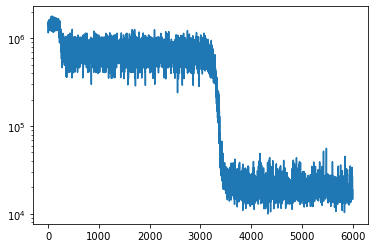

In [16]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [36]:
disp_lr = 1e-3
magnitude_lr = 1e-3
if not 'ux_uy_2d_v' in recons.optimizers:
    recons.setDisplacementAdamOptimizer(disp_lr)
else:
    recons.optimizers['ux_uy_2d_v']['learning_rate'].assign(disp_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'ux_uy_2d_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.001>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x154628c8f400>,
  'var': <tf.Variable 'ux_uy:0' shape=(16530,) dtype=float32, numpy=
  array([ 1.6727742,  1.8097464,  1.982158 , ..., -0.837557 , -0.8255141,
         -1.0146503], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.001>,
  'optimizer': <keras.optimizer_v2.adam.Adam at 0x154628c8f3a0>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(8268,) dtype=float32, numpy=
  array([-6.884925  , -6.389608  , -8.871706  , ..., -0.1337089 ,
         -0.62850785, -0.97845024], dtype=float32)>}}

In [37]:
recons.minimize(100, debug_output_epoch_frequency=10)

          epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
6060   1.01e+03    1.63e+04      0.705        0.7        0.373         0.42      0.372      0.336      0.446      0.406          0.349          0.309          0.428          0.385
6120   1.02e+03   2.48e+04      0.694      0.696       0.44      0.502       0.42      0.367      0.494       0.44        0.4      0.342      0.479      0.422
6180   1.03e+03   2.31e+04      0.768      0.758      0.614      0.599       0.45      0.391      0.513      0.467      0.432      0.369      0.499      0.451
6240   1.04e+03   1.72e+04      0.715      0.745      0.589      0.589      0.422       0.37      0.489      0.456      0.402      0.346      0.474      0.438
6300   1.05e+03   2.05e+04      0.722      0.719      0.562      0.558      0.418      0.373      0.479      0.455      0.398      0.349      0.463      0.438
6360

In [38]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = phase_cross_correlation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

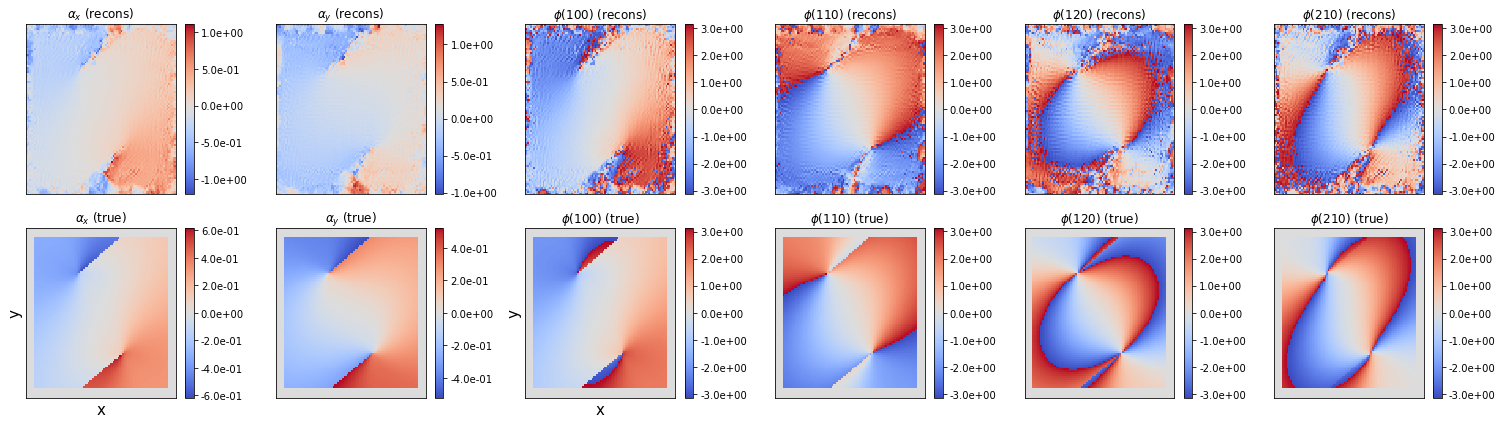

In [39]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

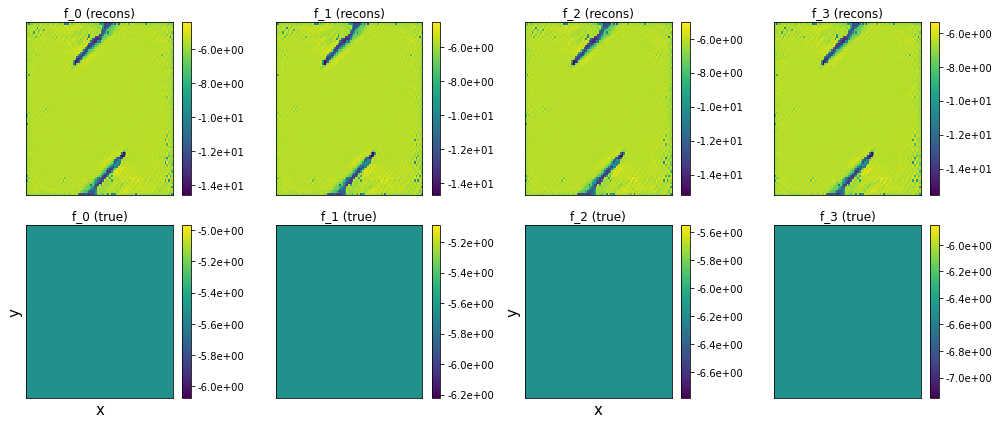

In [41]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][5:-5,5:-5])
    true_amplitudes = np.abs(recons._rho_true[i][5:-5,5:-5])
    
    cp0 = axs[0, i].pcolormesh(np.log(recons_amplitudes))
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(np.log(true_amplitudes))
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [42]:
recons.saveOutputsAndLog(data_path, prefix='direct_projected_')

In [43]:
!ls $data_path

direct_df_displacement_to_data_shared_mags.gz
direct_projected_df_displacement_to_data_shared_mags.gz
direct_projected_rho_displacement_to_data_shared_mags.npz
direct_projected_ux_displacement_to_data_shared_mags.npz
direct_projected_uy_displacement_to_data_shared_mags.npz
direct_rho_displacement_to_data_shared_mags.npz
direct_ux_displacement_to_data_shared_mags.npz
direct_uy_displacement_to_data_shared_mags.npz
sample_two_edge_slip.pkl
sim_two_edge_slip.pkl


In [44]:
import pandas as pd

In [45]:
dload = pd.read_pickle(f'{data_path}/direct_projected_df_displacement_to_data_shared_mags.gz')

In [46]:
dload.dropna()

,epoch,train_loss,err_ux,err_uy,err_ux_film,err_uy_film,err_rho0,err_rho1,err_rho2,err_rho3,err_rho_film0,err_rho_film1,err_rho_film2,err_rho_film3
6,1.0,1.572314e+06,0.778763,0.828799,0.722049,0.835731,0.925099,0.986876,0.959963,0.974784,0.905606,0.984290,0.954447,0.968771
12,2.0,1.474529e+06,0.768475,0.801325,0.707892,0.816215,0.894701,0.962559,0.936238,0.937974,0.867924,0.952394,0.916864,0.920289
18,3.0,1.452570e+06,0.773921,0.791109,0.705497,0.810601,0.871098,0.938910,0.945411,0.940312,0.838225,0.915277,0.910530,0.908279
24,4.0,1.490018e+06,0.784008,0.780246,0.726240,0.802040,0.848838,0.918934,0.947457,0.899597,0.819670,0.881083,0.921828,0.863126
30,5.0,1.625056e+06,0.851823,0.818357,0.779544,0.775288,0.830153,0.880087,0.899757,0.850700,0.797795,0.848324,0.869988,0.806686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6576,1096.0,1.699556e+04,0.701813,0.686564,0.532181,0.467711,0.424752,0.358468,0.471270,0.461977,0.404361,0.332682,0.454775,0.446269
6582,1097.0,2.326351e+04,0.696064,0.696665,0.533249,0.504973,0.422470,0.351675,0.471046,0.461314,0.402036,0.325248,0.454599,0.445822
6588,1098.0,1.559209e+04,0.703560,0.686049,0.521893,0.501886,0.429181,0.359171,0.473591,0.464927,0.409231,0.333453,0.457028,0.449416
6594,1099.0,1.761697e+04,0.684788,0.717043,0.474000,0.544861,0.429773,0.351580,0.472175,0.462612,0.409832,0.325267,0.455779,0.446941


In [47]:
ux = recons_items[r'$\alpha_x$']
uy = recons_items[r'$\alpha_y$']

In [48]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

In [49]:
sm.sample.params.lattice

array([0.0003905, 0.0003905, 0.0003905])

In [50]:

import matplotlib.colors as colors

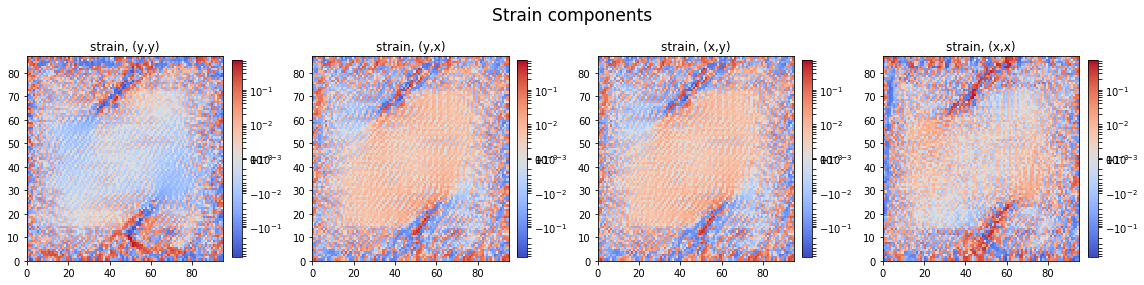

In [51]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [52]:
s.max(), s.min()

(0.870150089263916, -0.8179250955581665)

In [53]:
ux = true_items[r'$\alpha_x$']
uy = true_items[r'$\alpha_y$']

In [54]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

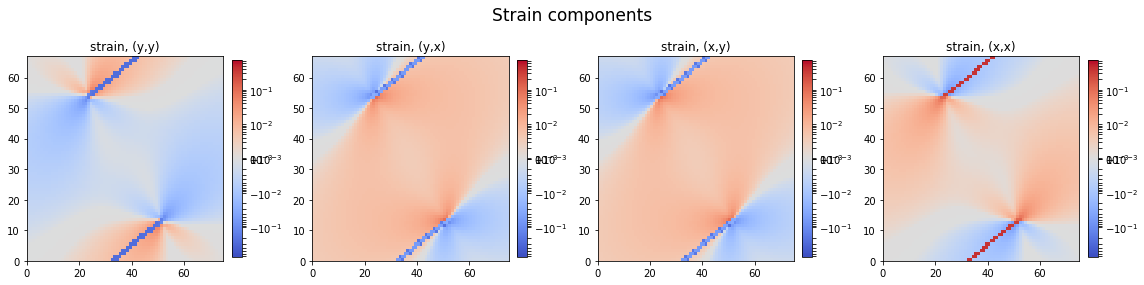

In [55]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-0.75, vmax=0.75))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  

In [56]:
sl.max()

0.40638076756532915

In [57]:
s.max(), s.min()

(0.40835473746468076, -0.27823352787413763)